In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', None)

In [ ]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [ ]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

print("\nSentiment Missing Values:")
print(sentiment.isna().sum())

print("\nTrades Missing Values:")
print(trades.isna().sum())

print("\nDuplicate Trades:", trades.duplicated().sum())

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)

Sentiment Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate Trades: 0


In [ ]:
# Convert date column
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['date'] = sentiment['date'].dt.date

# Keep only needed columns
sentiment = sentiment[['date', 'classification', 'value']]

In [ ]:
trades['Timestamp IST'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

trades['date'] = trades['Timestamp IST'].dt.date

In [ ]:
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Size USD'] = pd.to_numeric(trades['Size USD'], errors='coerce')
trades['Fee'] = pd.to_numeric(trades['Fee'], errors='coerce')

In [ ]:
trades = trades.dropna(subset=['Closed PnL'])

In [ ]:
trades['win'] = np.where(trades['Closed PnL'] > 0, 1, 0)

In [ ]:
trader_daily = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    total_fees=('Fee', 'sum'),
    win_rate=('win', 'mean')
).reset_index()

In [ ]:
trades['long'] = np.where(trades['Side'].str.upper() == 'BUY', 1, 0)

long_ratio = trades.groupby(['Account', 'date'])['long'].mean().reset_index()
long_ratio.rename(columns={'long': 'long_ratio'}, inplace=True)

trader_daily = trader_daily.merge(long_ratio, on=['Account', 'date'], how='left')

In [ ]:
daily_data = trader_daily.merge(sentiment, on='date', how='left')

print("Merged Shape:", daily_data.shape)

Merged Shape: (2341, 10)


In [ ]:
print("Missing sentiment rows:", daily_data['classification'].isna().sum())

Missing sentiment rows: 1


In [ ]:
performance_summary = daily_data.groupby('classification').agg(
    avg_daily_pnl=('daily_pnl', 'mean'),
    median_daily_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_count=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean')
)

print(performance_summary)

                avg_daily_pnl  median_daily_pnl  avg_win_rate  \
classification                                                  
Extreme Fear      4619.439053        218.377399      0.329659   
Extreme Greed     5161.922644        418.319862      0.386387   
Fear              5328.818161        107.892532      0.364033   
Greed             3318.100730        158.214922      0.343559   
Neutral           3438.618818        167.551743      0.355414   

                avg_trade_count  avg_trade_size  
classification                                   
Extreme Fear         133.750000     6773.464125  
Extreme Greed         76.030418     5371.637182  
Fear                  98.153968     8975.928546  
Greed                 77.628086     6427.866594  
Neutral              100.228723     6963.694861  


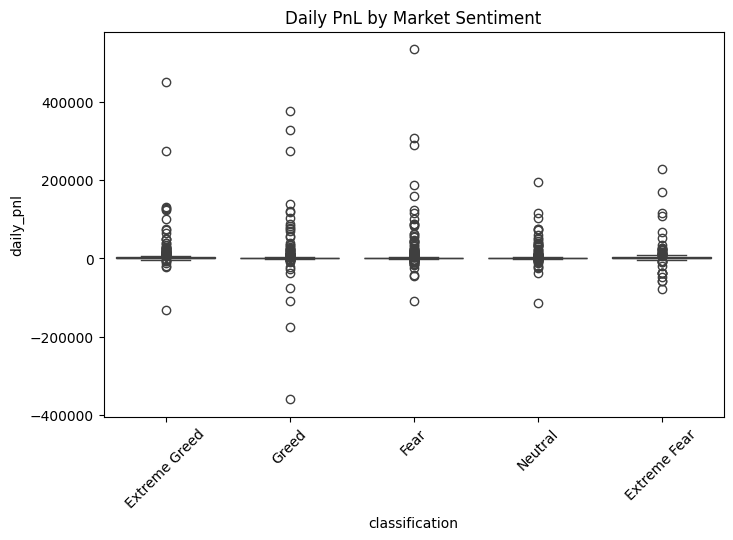

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=daily_data, x='classification', y='daily_pnl')
plt.title("Daily PnL by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

In [ ]:
fear = daily_data[daily_data['classification'] == 'Fear']['daily_pnl']
greed = daily_data[daily_data['classification'] == 'Greed']['daily_pnl']

t_stat, p_val = stats.ttest_ind(fear.dropna(), greed.dropna())

print("T-test p-value:", p_val)

T-test p-value: 0.24848965872471304


In [ ]:
behavior_summary = daily_data.groupby('classification').agg(
    avg_trade_count=('trade_count', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean'),
    avg_win_rate=('win_rate', 'mean')
)

print(behavior_summary)

                avg_trade_count  avg_trade_size  avg_long_ratio  avg_win_rate
classification                                                               
Extreme Fear         133.750000     6773.464125        0.531533      0.329659
Extreme Greed         76.030418     5371.637182        0.473116      0.386387
Fear                  98.153968     8975.928546        0.518967      0.364033
Greed                 77.628086     6427.866594        0.471594      0.343559
Neutral              100.228723     6963.694861        0.472431      0.355414


In [ ]:
freq_threshold = daily_data['trade_count'].median()

daily_data['frequency_segment'] = np.where(
    daily_data['trade_count'] >= freq_threshold,
    'Frequent',
    'Infrequent'
)

In [ ]:
segment_perf = daily_data.groupby(
    ['classification', 'frequency_segment']
)['daily_pnl'].mean().reset_index()

print(segment_perf)

  classification frequency_segment     daily_pnl
0   Extreme Fear          Frequent   6799.753651
1   Extreme Fear        Infrequent    457.020275
2  Extreme Greed          Frequent   8278.905236
3  Extreme Greed        Infrequent   1720.773862
4           Fear          Frequent  10225.889299
5           Fear        Infrequent    876.935309
6          Greed          Frequent   5387.784452
7          Greed        Infrequent   1419.870097
8        Neutral          Frequent   5652.453789
9        Neutral        Infrequent   1128.530152


In [ ]:
consistency = daily_data.groupby('Account')['win_rate'].mean().reset_index()
consistency.rename(columns={'win_rate': 'avg_win_rate'}, inplace=True)

threshold = consistency['avg_win_rate'].median()

consistency['consistency_segment'] = np.where(
    consistency['avg_win_rate'] >= threshold,
    'Consistent',
    'Inconsistent'
)

daily_data = daily_data.merge(consistency[['Account', 'consistency_segment']],
                              on='Account', how='left')

In [ ]:
daily_data = daily_data.sort_values(['Account', 'date'])

daily_data['cum_pnl'] = daily_data.groupby('Account')['daily_pnl'].cumsum()
daily_data['rolling_max'] = daily_data.groupby('Account')['cum_pnl'].cummax()
daily_data['drawdown'] = daily_data['cum_pnl'] - daily_data['rolling_max']

print(daily_data.groupby('classification')['drawdown'].mean())

classification
Extreme Fear     -9240.531028
Extreme Greed    -5504.652345
Fear             -8767.361384
Greed           -11642.727362
Neutral          -9431.377301
Name: drawdown, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

daily_data['next_day_pnl'] = daily_data.groupby('Account')['daily_pnl'].shift(-1)
daily_data['target'] = np.where(daily_data['next_day_pnl'] > 0, 1, 0)

daily_data['sentiment_encoded'] = daily_data['classification'].astype('category').cat.codes

features = ['sentiment_encoded', 'trade_count', 'avg_trade_size', 'long_ratio']
model_data = daily_data.dropna(subset=features + ['target'])

X = model_data[features]
y = model_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LogisticRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       196
           1       0.58      1.00      0.74       273

    accuracy                           0.58       469
   macro avg       0.79      0.50      0.37       469
weighted avg       0.76      0.58      0.43       469

